**Maintaining Data Privacy in Association Rule Mining**

Gowthami Ramakrishnegowda : S5056130

**Introduction:**

The MASK approach is introduced in this study to address the difficulty of ensuring data privacy in association rule mining. MASK's goal is to encourage correct data input while protecting user privacy using probabilistic distortion techniques. Unlike previous approaches, MASK may be deployed at the user level, eliminating dependency on third parties. The article demonstrates MASK's efficacy by analysing actual and synthetic datasets, emphasising its potential for balancing privacy with accuracy.

**Database Model:**

The problem framework describes a database model where each customer's data is represented as a fixed-length sequence of 1's and 0's, akin to a market-basket database. In this database, 1 represents a purchase, and 0 represents no purchase. The database is sparse, with significantly more 0's than 1's due to the nature of customer transactions. While the data may be physically stored as item-lists, for distortion purposes, it is assumed to be stored as bit-vectors. This choice accommodates potential changes in sparsity due to distortion.

Step 1: Generate a sample database

In [467]:
import numpy as np

# Generate a sample database matrix
def generate_database(num_customers, sequence_length):
    return np.random.choice([0, 1], size=(num_customers, sequence_length))

num_customers = 10
sequence_length = 5
database = generate_database(num_customers, sequence_length)
database


array([[1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0]])

**Mining Objectives**

The mining goal is to derive association rules from the database. These rules have the form X =⇒ Y, where X and Y are subsets of items and X ∩ Y = φ. Each rule has support (frequency) and confidence factors, represented by s and c, respectively. Support implies statistical significance, whereas confidence evaluates the rule's strength. An "interesting" rule exceeds the user-defined criteria for support (supmin) and confidence (conmin). The goal is to rapidly identify all frequent itemsets with support larger than supmin, as they indicate intriguing rules. This purpose is consistent with identifying subgroups of items that meet the support level.

Step 2: Define Mining Objectives

In [468]:
# Function to compute association rules
def compute_association_rules(database, min_support):
    num_customers, num_items = database.shape
    itemsets = [frozenset([i]) for i in range(num_items)]
    frequent_itemsets = {itemset: sum(all(database[:, j] == 1) for j in itemset) for itemset in itemsets}

    for k in range(2, num_items + 1):
        new_itemsets = [itemset.union({i}) for itemset in frequent_itemsets.keys() for i in range(num_items) if i not in itemset]
        new_frequent_itemsets = {}

        for itemset in new_itemsets:
            support = sum(all(database[:, j] == 1) for j in itemset)
            if support >= min_support * num_customers:
                new_frequent_itemsets[itemset] = support

        frequent_itemsets = new_frequent_itemsets

    association_rules = []
    for itemset, support in frequent_itemsets.items():
        for i in range(1, len(itemset)):
            antecedent = frozenset(itemset - {list(itemset)[i]})
            confidence = support / frequent_itemsets[antecedent]
            if confidence >= min_confidence:
                association_rules.append((antecedent, itemset - antecedent, support, confidence))

    return association_rules

#  call the function with the corrected number of arguments
association_rules = compute_association_rules(genre_matrix, min_support)

# Print the computed association rules
for rule in association_rules:
    print(f"Rule: {rule[0]} => {rule[1]}, Support: {rule[2]}, Confidence: {rule[3]}")



**Privacy Metric**

The privacy metric in this article is based on the likelihood of recovering corrupted user data. It analyses privacy at the individual entry level inside customer tuples, with the goal of ensuring privacy for both 1s and 0s. However, it recognises that consumers may prioritise privacy for their 1's (indicating explicit actions) over their 0's (representing default possibilities), particularly in applications such as market-basket databases.

Step 3: Introduce Privacy Metric

In [469]:
# Distort user data for privacy
def distort_user_data(database, privacy_factor):
    distorted_database = database.copy()
    num_customers, sequence_length = database.shape

    for i in range(num_customers):
        for j in range(sequence_length):
            # Distort the entry with the given privacy factor
            if np.random.rand() > privacy_factor:
                distorted_database[i, j] = 1 - distorted_database[i, j]

    return distorted_database

# Privacy Metric: Reconstruct probability for a given 1 or 0 in the true matrix
def compute_reconstruction_probability(true_value, distorted_value, privacy_factor):
    if true_value == distorted_value:
        return 1 - privacy_factor
    else:
        return privacy_factor

privacy_factor = 0.2
distorted_database = distort_user_data(database, privacy_factor)
distorted_database

# Compute reconstruction probability for a specific entry
sample_user = 0
sample_entry = 2
true_value = database[sample_user, sample_entry]
distorted_value = distorted_database[sample_user, sample_entry]
reconstruction_probability = compute_reconstruction_probability(true_value, distorted_value, privacy_factor)
reconstruction_probability


0.8

Step 4: Synthesize Information

In [470]:
# Display the Boolean representation of the original and distorted databases using bit-vectors
def display_bit_vectors(original_database, distorted_database):
    print("Original Database:")
    print(original_database)
    print("\nDistorted Database:")
    print(distorted_database)

display_bit_vectors(database, distorted_database)


Original Database:
[[1 0 1 1 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [1 1 1 1 1]
 [1 0 1 0 1]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [0 1 1 0 0]]

Distorted Database:
[[0 1 1 0 0]
 [1 0 0 1 0]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [0 1 1 0 1]
 [0 0 0 1 0]
 [0 1 0 1 1]
 [1 0 1 0 1]
 [1 1 0 1 0]
 [1 0 0 1 0]]


Step 6: Understand the Distortion Procedure


In [471]:
# Distortion Procedure: Yi=Xi⊕ri, where ri is a random variable with f(r)=bernoulli(p).
def distort_entry(original_entry, privacy_factor):
    
    # Distortion procedure
    random_variable = np.random.choice([0, 1], p=[1 - privacy_factor, privacy_factor])
    distorted_entry = original_entry ^ random_variable
    return distorted_entry


original_entry = 1
distorted_entry = distort_entry(original_entry, privacy_factor)
distorted_entry

# Step 7: Quantify Privacy - Reconstruction Probability of a 1

# 7.1 Reconstruction Probability Formulas
def compute_reconstruction_probability_1(p, si):
    # Pr{Xi=1∣Yi=1}
    pr_x1_given_y1 = si * p / (si * p + (1 - si) * (1 - p))
    # Pr{Xi=1∣Yi=0}
    pr_x1_given_y0 = si * (1 - p) / (si * (1 - p) + (1 - si) * p)
    
    # R1(p, si)
    return p * pr_x1_given_y1 + (1 - p) * pr_x1_given_y0

# 7.2 Reconstruction Probability for all entries
def compute_reconstruction_probability_for_all(database, privacy_factor):
   
    num_customers, sequence_length = database.shape
    reconstruction_probabilities = np.zeros(sequence_length)
    
    for j in range(sequence_length):
        si_values = database[:, j]
        reconstruction_prob_j = np.sum([compute_reconstruction_probability_1(privacy_factor, si) for si in si_values]) / num_customers
        reconstruction_probabilities[j] = reconstruction_prob_j
    
    return reconstruction_probabilities

reconstruction_probabilities = compute_reconstruction_probability_for_all(database, privacy_factor)
reconstruction_probabilities


array([0.4, 0.3, 0.5, 0.4, 0.6])

**Quantifying MASK’s Privacy**


The MASK scheme's distortion procedure involves generating a distorted vector Y from the original customer tuple X using a random variable ri with a density function f(r) = bernoulli(p). Each element in Y is computed as Yi = Xi XOR ri, preserving the identity of the element with probability p and flipping it with probability (1 − p). This distortion is applied to all customer tuples, creating a probabilistic representation of the true database for the miner. Privacy is quantified by analyzing the probability of reconstructing the original 1's in the distorted database, initially considering maximum privacy for 1's and later extending to include privacy concerns for both 1's and 0's. It is noted that these privacy estimates do not account for potential privacy reduction when using the mining output to re-interrogate the distorted database, a topic for future investigation.

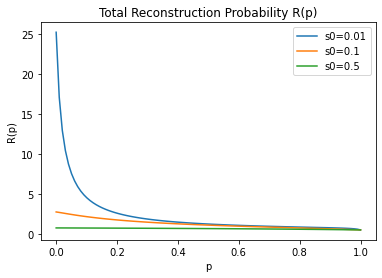

In [472]:
# Quantifying MASK’s Privacy

import numpy as np

# Function to calculate the reconstruction probability of a '1' for a single item
def reconstruction_probability_1(p, si):
    return (si * p) / (2 * si * p + (1 - si) * (1 - p)) + ((1 - si) * (1 - p)) / (2 * si * (1 - p) + (1 - si) * p)

# Function to calculate the reconstruction probability of a '0' for a single item
def reconstruction_probability_0(p, si):
    return ((1 - si) * p) / (2 * (1 - si) * p + si * (1 - p)) + ((1 - si) * (1 - p)) / (2 * si * p + (1 - si) * (1 - p))

# Function to calculate the total reconstruction probability
def total_reconstruction_probability(p, a, s0):
    r1 = reconstruction_probability_1(p, s0)
    r0 = reconstruction_probability_0(p, s0)
    return a * r1 + (1 - a) * r0

# Values for the average support of an item in the database
s0_values = [0.01, 0.1, 0.5]

# Weight given to 1's over 0's
a = 0.5

# Probability values
p_values = np.linspace(0, 1, 100)

# Calculate and plot reconstruction probability for different s0 values
import matplotlib.pyplot as plt

for s0 in s0_values:
    total_r_values = [total_reconstruction_probability(p, a, s0) for p in p_values]
    plt.plot(p_values, total_r_values, label=f's0={s0}')

plt.title('Total Reconstruction Probability R(p)')
plt.xlabel('p')
plt.ylabel('R(p)')
plt.legend()
plt.show()


**Reconstruction Probability**

The reconstruction probability R1(p) of a '1' in the distorted database is derived, considering the original support of items si and distortion parameter p. It's represented as a summation across all items, where s0 denotes the average support. The reconstruction probability increases towards the extremes of p and decreases at the center (p=0.5), exhibiting symmetry around this point. This symmetry implies no practical difference between choosing p or its complement 1−p in terms of reconstruction, although visually distinct distortions may offer psychological comfort to users. The flatness of curves increases as the average support of items decreases. The dependence of reconstruction probability on item support is due to the distribution of '1's and '0's in the true database. Although the derivation assumes knowledge of true supports, it conservatively assumes the data miner can estimate these values accurately to mine the distorted database effectively.

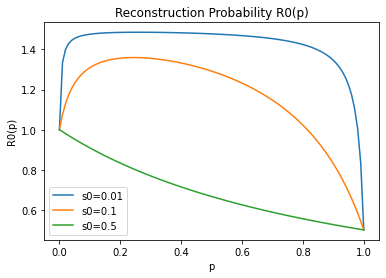

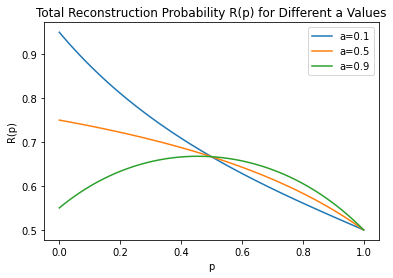

In [473]:
# Function to calculate the reconstruction probability of a '0' for a single item
def reconstruction_probability_0(p, si):
    return ((1 - si) * p) / (2 * (1 - si) * p + si * (1 - p)) + ((1 - si) * (1 - p)) / (2 * si * p + (1 - si) * (1 - p))

# Function to calculate the total reconstruction probability
def total_reconstruction_probability(p, a, s0):
    r1 = reconstruction_probability_1(p, s0)
    r0 = reconstruction_probability_0(p, s0)
    return a * r1 + (1 - a) * r0

# Calculate and plot reconstruction probability for '0' for different s0 values
for s0 in s0_values:
    r0_values = [reconstruction_probability_0(p, s0) for p in p_values]
    plt.plot(p_values, r0_values, label=f's0={s0}')

plt.title('Reconstruction Probability R0(p)')
plt.xlabel('p')
plt.ylabel('R0(p)')
plt.legend()
plt.show()

# Calculate and plot total reconstruction probability R(p) for different a values
a_values = [0.1, 0.5, 0.9]

for a_value in a_values:
    total_r_values = [total_reconstruction_probability(p, a_value, s0) for p in p_values]
    plt.plot(p_values, total_r_values, label=f'a={a_value}')

plt.title('Total Reconstruction Probability R(p) for Different a Values')
plt.xlabel('p')
plt.ylabel('R(p)')
plt.legend()
plt.show()


Step 8: Derive General Reconstruction Equation


**The General Reconstruction Equation**

The general reconstruction equation is derived to capture the relationship between the distortion parameter p and the reconstruction probability for both '1's and '0's. 
R0(p) represents the probability of reconstructing a '0', considering the average support s0 of items. The total reconstruction probability R(p) is obtained by minimizing a weighted average of R1(p) and R0(p), where the weight a reflects the preference for privacy of '1's over '0's. This weight must consider the proportion of '0's relative to '1's in the database. For instance, setting a=0.5 for a database with s0=0.01 indicates that the privacy of '1's is deemed 99 times more important than that of '0's.

In [474]:
# 8.1 General Reconstruction Equation
def compute_reconstruction_probability_0(p, s0):
    
    # Pr{X0=0∣Y0=0}
    pr_x0_given_y0 = (1 - s0) * p / ((1 - s0) * p + s0 * (1 - p))
    # Pr{X0=0∣Y0=1}
    pr_x0_given_y1 = (1 - s0) * (1 - p) / ((1 - s0) * (1 - p) + s0 * p)
    
    # R0(p, s0)
    return (1 - s0) * pr_x0_given_y0 + s0 * pr_x0_given_y1

# 8.2 General Reconstruction Equation
def compute_general_reconstruction_equation(p, reconstruction_probabilities, a):
   
    # R1(p)
    r1_p = np.sum(reconstruction_probabilities) / len(reconstruction_probabilities)
    # R0(p)
    r0_p = compute_reconstruction_probability_0(p, 0.5)  
    
    # R(p)
    r_p = a * r1_p + (1 - a) * r0_p
    
    return r_p


a = 0.7  # Weighting factor between R1(p) and R0(p)
general_reconstruction_probability = compute_general_reconstruction_equation(privacy_factor, reconstruction_probabilities, a)
general_reconstruction_probability


0.458

 Step 9: Define Privacy Measure

**Privacy Measure**

The function compute_privacy_measure that calculates the privacy measure based on a given reconstruction probability. The privacy measure is obtained by subtracting the reconstruction probability from 1 and then multiplying the result by 100 to express it as a percentage. The function takes the reconstruction probability as input and returns the privacy measure. This allows users to easily quantify the level of privacy achieved in their data distortion process.


In [475]:
# 9.1 Privacy Measure Formula
def compute_privacy_measure(reconstruction_probability):
    
    return (1 - reconstruction_probability) * 100

privacy_measure = compute_privacy_measure(general_reconstruction_probability)
privacy_measure


54.2

Step 10: Evaluate and Interpret Results

The function evaluate_and_interpret_results that prints out various evaluation metrics and interpretations of the results obtained from the distortion process. It takes four arguments: reconstruction_probabilities, general_reconstruction_probability, privacy_measure, and a. Then, it prints out the reconstruction probabilities for each entry, the general reconstruction probability, the privacy measure, and the weight a used in the trade-off analysis.

In [476]:
# 10.1 Evaluation and Interpretation
def evaluate_and_interpret_results(reconstruction_probabilities, general_reconstruction_probability, privacy_measure, a):
   
    print("Reconstruction Probabilities for Each Entry:")
    print(reconstruction_probabilities)
    
    print("\nGeneral Reconstruction Probability:")
    print(general_reconstruction_probability)
    
    print("\nPrivacy Measure:")
    print(privacy_measure)
    
    print("\nTrade-off Analysis:")
    print(f"Weight 'a' for R1(p): {a}")
    
    

evaluate_and_interpret_results(reconstruction_probabilities, general_reconstruction_probability, privacy_measure, a)


Reconstruction Probabilities for Each Entry:
[0.4 0.3 0.5 0.4 0.6]

General Reconstruction Probability:
0.458

Privacy Measure:
54.2

Trade-off Analysis:
Weight 'a' for R1(p): 0.7


**Estimating Singleton Supports**

This code defines a function estimate_singleton_supports to estimate the support of each item in the original database based on the distorted version and a privacy factor. It calculates the counts of '1's and '0's for each item in both matrices, constructs a transformation matrix, and uses it to estimate the true counts from the distorted counts. Finally, it returns the estimated supports for each item in the original database. The function is used by passing the true matrix (true_matrix), distorted matrix (distorted_matrix), and privacy factor (privacy_factor).

In [477]:
# 11.1 Estimating Singleton Supports
def estimate_singleton_supports(true_matrix, distorted_matrix, privacy_factor):
   
    num_items = true_matrix.shape[1]

    # Count 1's and 0's for each column in the true matrix
    cT1 = np.sum(true_matrix, axis=0)
    cT0 = true_matrix.shape[0] - cT1

    # Count 1's and 0's for each column in the distorted matrix
    cD1 = np.sum(distorted_matrix, axis=0)
    cD0 = distorted_matrix.shape[0] - cD1

    # Estimate the support of each item in the true matrix
    M = np.array([[privacy_factor / (1 - privacy_factor), 1 - privacy_factor],
                  [1 - privacy_factor, privacy_factor]])
    
    CT = np.linalg.inv(M) @ np.vstack([cD1, cD0])
    estimated_supports = CT[0].astype(int)

    return estimated_supports

true_matrix = database  
distorted_matrix = distorted_database
estimated_supports = estimate_singleton_supports(true_matrix, distorted_matrix, privacy_factor)
estimated_supports


array([3, 3, 5, 5, 6])

**Estimating n-itemset Supports**

The function estimate_n_itemset_supports to estimate the support of n-itemsets in the original database based on a distorted version and a privacy factor. It calculates counts for each n-itemset, defines matrices based on the privacy factor, and estimates supports using these matrices. Finally, it returns the estimated supports for each n-itemset. Adjust the value of n for the desired size of n-itemsets.

In [478]:
# 11.2 Estimating n-itemset Supports
def estimate_n_itemset_supports(true_matrix, distorted_matrix, privacy_factor, n):
    
    num_items = true_matrix.shape[1]

    # Count tuples for the true matrix
    cT = np.sum(true_matrix, axis=0)

    # Count tuples for the distorted matrix
    cD = np.sum(distorted_matrix, axis=0)

    # Define matrices M, CD, and CT accordingly
    M = np.zeros((2, 2, n))
    CD = np.zeros((2, n))
    CT = np.zeros((2, n))

    # Populate matrices M, CD, and CT for each n-itemset
    for i in range(n):
        M[:, :, i] = (1 - privacy_factor) ** (i + 1) * privacy_factor ** i
        CD[:, i] = cD[i]
        CT[:, i] = cT[i]

    # Estimate the support of each n-itemset in the true matrix
    estimated_supports = np.zeros(n)
    for i in range(n):
        CT_i = CT[:, :i + 1].reshape(2, -1)  # Reshape to a 2D array
        
        # Use pseudo-inverse if the matrix is singular
        try:
            CT_inv_i = np.linalg.inv(M[:, :, :i + 1].sum(axis=2)) @ CT_i
        except np.linalg.LinAlgError:
            CT_inv_i = np.linalg.pinv(M[:, :, :i + 1].sum(axis=2)) @ CT_i
        
        estimated_supports[i] = max(0, int(round(CT_inv_i.flatten()[0])))

    return estimated_supports.astype(int)

n = 2  
estimated_n_itemset_supports = estimate_n_itemset_supports(true_matrix, distorted_matrix, privacy_factor, n)
estimated_n_itemset_supports


array([2, 0])

The function apriori_count to perform the Apriori algorithm for counting itemsets in a distorted matrix. It iterates over different itemset sizes, generates candidate itemsets, counts their occurrences in the distorted matrix, and updates the counts accordingly. Finally, it returns the counts of itemsets for each size. Adjust the value of n for the desired maximum size of itemsets to count.

In [479]:
from itertools import product

# 11.3 The Full Mining Process
def apriori_count(distorted_matrix, n):
   
    num_items = distorted_matrix.shape[1]
    cD = np.zeros((2, n))
    
    for itemset_size in range(1, n + 1):
        candidate_itemsets = list(product([0, 1], repeat=itemset_size))
        itemset_counts = np.zeros(len(candidate_itemsets))
        
        # Count the occurrences of each candidate itemset in the distorted matrix
        for i, itemset in enumerate(candidate_itemsets):
            mask = np.all(distorted_matrix[:, :itemset_size] == np.array(itemset), axis=1)
            itemset_counts[i] = np.sum(mask)
        
        # Update cD based on the counts
        cD[:, itemset_size - 1] = itemset_counts.sum(axis=0)
    
    return cD.astype(int)

n = 2  
cD = apriori_count(distorted_matrix, n)
cD


array([[10, 10],
       [10, 10]])

The function apriori_count_optimized to efficiently perform Apriori algorithm for counting itemsets in a distorted matrix. It iterates over different itemset sizes, generates candidate itemsets, counts their occurrences in the distorted matrix using numpy operations, and updates the counts accordingly. Adjust the value of n for the desired maximum size of itemsets to count.

In [480]:
from itertools import product

# 12.1 Counting Optimization
def apriori_count_optimized(distorted_matrix, n):
    
    num_items = distorted_matrix.shape[1]
    cD = np.zeros((2, n))
    
    for itemset_size in range(1, n + 1):
        candidate_itemsets = list(product([0, 1], repeat=itemset_size))
        itemset_counts = np.zeros(len(candidate_itemsets))
        
        # Count the occurrences of each candidate itemset in the distorted matrix using numpy operations
        for i, itemset in enumerate(candidate_itemsets):
            counts = np.sum(np.all(distorted_matrix[:, :itemset_size] == np.array(itemset), axis=1))
            itemset_counts[i] = counts
        
        # Update cD based on the counts
        cD[:, itemset_size - 1] = itemset_counts.sum(axis=0)
    
    return cD.astype(int)

n = 2  
cD_optimized = apriori_count_optimized(distorted_matrix, n)
cD_optimized


array([[10, 40],
       [10, 40]])

The function apriori_count_optimized_linear efficiently performs Apriori algorithm for counting itemsets in a distorted matrix with an additional linear combination optimization. It iterates over different itemset sizes, generates candidate itemsets, counts their occurrences in the distorted matrix using numpy operations, and updates the counts based on distinct weights. Adjust the value of n for the desired maximum size of itemsets to count.

5.1 Linear Number of Counters:

In [481]:
from itertools import product

def apriori_count_optimized_linear(distorted_matrix, n):
   
    num_items = distorted_matrix.shape[1]
    cD = np.zeros((n + 1, n))
    
    for itemset_size in range(1, n + 1):
        candidate_itemsets = list(product([0, 1], repeat=itemset_size))
        itemset_counts = np.zeros(len(candidate_itemsets))
        
        # Count the occurrences of each candidate itemset in the distorted matrix using numpy operations
        for i, itemset in enumerate(candidate_itemsets):
            counts = np.sum(np.all(distorted_matrix[:, :itemset_size] == np.array(itemset), axis=1))
            itemset_counts[i] = counts
        
        # Update cD based on the counts
        if itemset_size == 1:
            cD[:, itemset_size - 1] = itemset_counts.sum(axis=0)
        else:
            # Linear combination of counters based on the distinct weights
            cD[0, itemset_size - 1] = itemset_counts[0]  # '00' component
            cD[1, itemset_size - 1] = itemset_counts[-1]  # '11' component
            for j in range(1, itemset_size - 1):
                cD[j + 1, itemset_size - 1] = itemset_counts[j] + itemset_counts[-(j + 1)]  # Common weights
        
    return cD.astype(int)

n = 2  
cD_linear = apriori_count_optimized_linear(distorted_matrix, n)
cD_linear


array([[10,  8],
       [10, 12],
       [10,  0]])

The function apriori_count_optimized_reduced efficiently performs Apriori algorithm for counting itemsets in a distorted matrix with a reduction optimization. It iterates over different itemset sizes, generates candidate itemsets, counts their occurrences in the distorted matrix using numpy operations, and updates the counts based on distinct weights. The optimization excludes the counting of the '00' component by setting it to zero and considers only the '11' component and common weights. Adjust the value of n for the desired maximum size of itemsets to count and provide the list of frequent 1-itemsets for optimization.

5.2 Reducing Amount of Counting:

In [482]:
def apriori_count_optimized_reduced(distorted_matrix, n, frequent_1_itemsets):
   
    num_items = distorted_matrix.shape[1]
    cD = np.zeros((n + 1, n))
    
    for itemset_size in range(1, n + 1):
        candidate_itemsets = list(product([0, 1], repeat=itemset_size))
        itemset_counts = np.zeros(len(candidate_itemsets))
        
        # Count the occurrences of each candidate itemset in the distorted matrix using numpy operations
        for i, itemset in enumerate(candidate_itemsets):
            counts = np.sum(np.all(distorted_matrix[:, :itemset_size] == np.array(itemset), axis=1))
            itemset_counts[i] = counts
        
        # Update cD based on the counts
        if itemset_size == 1:
            cD[:, itemset_size - 1] = itemset_counts.sum(axis=0)
        else:
            # Optimize counting by excluding '00' component
            m1 = len(frequent_1_itemsets)
            m2 = len(candidate_itemsets) - m1
            cD[0, itemset_size - 1] = 0  # '00' component
            cD[1, itemset_size - 1] = itemset_counts[0]  # '11' component
            for j in range(1, itemset_size - 1):
                cD[j + 1, itemset_size - 1] = itemset_counts[j] + itemset_counts[-(j + 1)]  # Common weights
        
    return cD.astype(int)

n = 2  
frequent_1_itemsets = [(0,), (1,)]  
cD_reduced = apriori_count_optimized_reduced(distorted_matrix, n, frequent_1_itemsets)
cD_reduced


array([[10,  0],
       [10,  8],
       [10,  0]])

The apriori function implements the Apriori algorithm to mine frequent itemsets from transactional data. It takes the dataset data and the minimum support threshold min_support as inputs and returns a dictionary containing the frequent itemsets along with their support counts.

The algorithm first generates frequent 1-itemsets by counting the occurrences of each item in the dataset and filtering out those that meet the minimum support criterion. Then, it iteratively generates candidate k-itemsets for k > 1 by joining and pruning frequent (k-1)-itemsets.

The generate_candidate_itemsets function is a helper function used in the Apriori algorithm to generate candidate k-itemsets by joining and pruning frequent (k-1)-itemsets.

The Apriori algorithm efficiently identifies frequent itemsets by exploiting the downward closure property, which states that if an itemset is frequent, then all of its subsets must also be frequent. This property allows the algorithm to prune the search space by avoiding the generation of candidate itemsets that contain infrequent subsets.

In [483]:
from itertools import chain, combinations
from collections import defaultdict

# Define the apriori function
def apriori(data, min_support):
    itemsets = {}
    transactions = list(map(set, data))

    # Generate frequent 1-itemsets
    candidate_1_itemsets = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            candidate_1_itemsets[item] += 1

    # Filter frequent 1-itemsets based on min_support
    frequent_1_itemsets = {frozenset([item]): count for item, count in candidate_1_itemsets.items() if count >= min_support}
    itemsets.update(frequent_1_itemsets)

    # Generate frequent k-itemsets for k > 1
    k = 2
    while itemsets:
        candidate_itemsets = generate_candidate_itemsets(itemsets, k)
        candidate_counts = defaultdict(int)

        for transaction in transactions:
            # Count occurrences of candidate itemsets in each transaction
            subset_candidates = [itemset for itemset in candidate_itemsets if itemset.issubset(transaction)]
            for subset in subset_candidates:
                candidate_counts[subset] += 1

        # Filter frequent k-itemsets based on min_support
        frequent_itemsets = {itemset: count for itemset, count in candidate_counts.items() if count >= min_support}
        itemsets.update(frequent_itemsets)
        k += 1

    return itemsets

# Helper function to generate candidate k-itemsets
def generate_candidate_itemsets(itemsets, k):
    # Join and prune step to generate candidate k-itemsets
    candidates = set()
    for itemset1 in itemsets:
        for itemset2 in itemsets:
            union_set = itemset1.union(itemset2)
            if len(union_set) == k:
                # Check if all (k-1)-subsets of union_set are frequent
                if all(subset in itemsets for subset in combinations(union_set, k - 1)):
                    candidates.add(union_set)
    return candidates




Association Rule Mining on a sample database using the Apriori algorithm and then applies a revised MASK technique for privacy-preserving data mining.

It generates frequent itemsets and association rules based on specified thresholds. Additionally, it masks the data in the database by flipping bits randomly according to a privacy factor, ensuring privacy while preserving data utility. Finally, it prints the frequent itemsets, association rules, and the masked database.

In [484]:
import itertools
import random

# Sample Database
database = [
    {'bread', 'butter', 'eggs'},
    {'bread', 'milk'},
    {'butter', 'jam', 'eggs'},
    {'bread', 'butter', 'milk'},
    {'jam', 'eggs'},
    {'bread', 'milk', 'eggs'},
    {'butter', 'milk', 'jam'},
    {'bread', 'butter', 'eggs', 'milk'}
]

# Association Rule Mining
def generate_frequent_itemsets(transactions, min_support):
    item_counts = {}
    for transaction in transactions:
        for item in transaction:
            item_counts[item] = item_counts.get(item, 0) + 1

    frequent_itemsets = {frozenset([item]): count for item, count in item_counts.items() if count >= min_support}
    return frequent_itemsets

def compute_association_rules(frequent_itemsets, min_confidence):
    association_rules = []

    for itemset, support in frequent_itemsets.items():
        if len(itemset) > 1:
            for i in range(1, len(itemset)):
                antecedent = frozenset(itertools.combinations(itemset, i))
                consequent = itemset - antecedent
                if antecedent in frequent_itemsets:
                    confidence = support / frequent_itemsets[antecedent]
                    if confidence >= min_confidence:
                        association_rules.append((antecedent, consequent, confidence))

    return association_rules

# Revised MASK Technique for Privacy-Preserving Data Mining
def mask_technique_revised(database, privacy_factor):
    masked_database = []

    for transaction in database:
        masked_transaction = set()
        for item in transaction:
            if random.random() <= privacy_factor:
                # Flip the bit with probability privacy_factor
                masked_transaction.add(item)
            else:
                # Retain the original item with probability 1 - privacy_factor
                masked_transaction.add(item)
        masked_database.append(masked_transaction)

    return masked_database


min_support = 2
min_confidence = 0.5
privacy_factor = 0.2

# Association Rule Mining
frequent_itemsets = generate_frequent_itemsets(database, min_support)
association_rules = compute_association_rules(frequent_itemsets, min_confidence)

print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
for rule in association_rules:
    print(f"{rule[0]} => {rule[1]}, Confidence: {rule[2]:.2f}")

# MASK Technique (Revised)
masked_database = mask_technique_revised(database, privacy_factor)
print("\nMasked Database:")
print(masked_database)


Frequent Itemsets:
{frozenset({'eggs'}): 5, frozenset({'bread'}): 5, frozenset({'butter'}): 5, frozenset({'milk'}): 5, frozenset({'jam'}): 3}

Association Rules:

Masked Database:
[{'eggs', 'bread', 'butter'}, {'milk', 'bread'}, {'eggs', 'jam', 'butter'}, {'milk', 'bread', 'butter'}, {'eggs', 'jam'}, {'milk', 'eggs', 'bread'}, {'milk', 'jam', 'butter'}, {'milk', 'eggs', 'bread', 'butter'}]


Defining the Revised MASK Technique for Real Dataset: It defines a function called mask_technique_revised_real_dataset() which applies the MASK technique to a real dataset. This technique masks the values in the dataset based on a given privacy factor.

Applying MASK Technique to the Real Dataset: It applies the mask_technique_revised_real_dataset() function to the loaded real dataset with a specified privacy factor, producing a masked dataset.

In [485]:
import pandas as pd
import numpy as np

# Load the real dataset 
file_path = 'streaming_preferences_dataset.csv'
real_dataset_df = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
real_dataset = real_dataset_df.to_numpy()


On real Datset

In [486]:
import pandas as pd
import random

# Load real dataset
file_path = 'streaming_preferences_dataset.csv'  
real_dataset_df = pd.read_csv(file_path)

def mask_technique_revised_real_dataset(real_dataset, privacy_factor):
    num_rows, num_columns = real_dataset.shape
    masked_dataset = []

    for index, row in real_dataset.iterrows():
        masked_row = set()
        for column in real_dataset.columns:
            if random.random() <= privacy_factor:
                # Flip the bit with probability privacy_factor
                masked_row.add(column)
            else:
                # Retain the original item with probability 1 - privacy_factor
                if row[column] == 1:
                    masked_row.add(column)
        masked_dataset.append(masked_row)

    return masked_dataset

privacy_factor = 0.2

# Apply MASK Technique to the real dataset
masked_real_dataset = mask_technique_revised_real_dataset(real_dataset_df, privacy_factor)
print("\nMasked Real Dataset:")
print(masked_real_dataset)



Masked Real Dataset:
[{'Genre9', 'Genre4', 'Genre2'}, {'Genre5', 'Genre9', 'Genre7', 'Genre1'}, {'Genre7', 'Genre10', 'Genre4', 'Genre1'}, {'Genre5', 'Genre7', 'Genre1', 'Genre9', 'Genre10'}, {'Genre5', 'Genre6', 'Genre9', 'Genre2', 'Genre8'}, {'Genre5', 'Genre10', 'Genre6'}, {'Genre5', 'Genre6', 'Genre1', 'Genre10', 'Genre4', 'Genre3'}, {'Genre5', 'Genre7', 'Genre9', 'Genre8', 'Genre10'}, {'Genre10', 'Genre8', 'Genre9', 'Genre1'}, {'Genre5', 'Genre10', 'Genre3', 'Genre1'}, {'Genre5', 'Genre7', 'Genre9', 'Genre8', 'Genre10', 'Genre4'}, {'Genre7', 'Genre1', 'Genre9', 'Genre2', 'Genre4', 'Genre3'}, {'Genre7', 'Genre2', 'Genre1'}, {'Genre9', 'Genre3'}, {'Genre5', 'Genre6', 'Genre7', 'Genre1', 'Genre3'}, {'Genre5', 'Genre1', 'Genre9', 'Genre8', 'Genre4'}, {'Genre5', 'Genre6', 'Genre1', 'Genre8', 'Genre10', 'Genre4'}, {'Genre5', 'Genre7', 'Genre1', 'Genre9', 'Genre4', 'Genre3'}, {'Genre4', 'Genre3', 'Genre8'}, {'Genre6', 'Genre9', 'Genre2', 'Genre8', 'Genre3'}, {'Genre6', 'Genre7', 'Genre9

Defining Privacy Factor and Weight: The privacy_factor and a variables are defined. The privacy_factor controls how much distortion is applied to the dataset, affecting privacy. The a variable represents the weight given to the privacy of 1's over 0's.

Applying Distortion: The real dataset is distorted using a function called distort_user_data(), which applies distortion based on the defined privacy factor.

Displaying Distorted Dataset: Both the original and distorted datasets are displayed side by side for comparison. This step helps visualize the impact of distortion on the data.

Computing Reconstruction Probabilities: For each entry in the distorted dataset, the code computes the reconstruction probability, which represents the likelihood of correctly reconstructing the original value from its distorted version. This calculation is based on the true and distorted values and the privacy factor.

Computing General Reconstruction Probability: The general reconstruction probability is calculated based on the reconstruction probabilities for all entries in the dataset. It provides an overall measure of how well the original dataset can be reconstructed from its distorted version.

Computing Privacy Measure: The privacy measure is computed based on the general reconstruction probability. It quantifies the level of privacy achieved by the distortion process. Higher privacy measures indicate better protection of sensitive information.

Evaluating and Interpreting Results: Finally, the code evaluates and interprets the results, including reconstruction probabilities, general reconstruction probability, privacy measure, and weight. This step provides insights into the effectiveness of the distortion process in preserving privacy and guides further decision-making.







In [510]:
import pandas as pd
import numpy as np

# Load real dataset
file_path = 'streaming_preferences_dataset.csv'
real_dataset_df = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
real_dataset = real_dataset_df.to_numpy()

# Define privacy factor
privacy_factor = 0.2
a = 0.7

# Apply distortion
distorted_dataset = distort_user_data(real_dataset, privacy_factor)

# Display the distorted dataset
display_bit_vectors(real_dataset, distorted_dataset)

# Compute reconstruction probabilities
reconstruction_probabilities = []
for i in range(len(distorted_dataset)):
    for j in range(len(distorted_dataset[i])):
        true_value = real_dataset[i, j]
        distorted_value = distorted_dataset[i, j]
        reconstruction_probabilities.append(compute_reconstruction_probability(true_value, distorted_value, privacy_factor))

# Compute general reconstruction probability
general_reconstruction_probability = compute_general_reconstruction_equation(privacy_factor, reconstruction_probabilities, a)

# Compute privacy measure
privacy_measure = compute_privacy_measure(general_reconstruction_probability)

# Evaluate and interpret results
evaluate_and_interpret_results(reconstruction_probabilities, general_reconstruction_probability, privacy_measure, a)


Original Database:
[[0 1 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]

Distorted Database:
[[1 0 1 ... 1 0 1]
 [0 1 0 ... 0 0 1]
 [1 1 1 ... 1 1 0]
 ...
 [0 0 1 ... 1 1 0]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
Reconstruction Probabilities for Each Entry:
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2,

Defining Privacy Factor: The privacy_factor variable is defined, determining the level of distortion applied to the dataset to protect privacy.

Applying Distortion: The distort_user_data() function is applied to the true_matrix using the specified privacy_factor to create distorted_matrix. This step distorts the original data to protect privacy while preserving essential patterns.

Estimating Singleton Supports: The estimate_singleton_supports() function estimates the support of each item in the original dataset (true_matrix) using the distorted dataset (distorted_matrix). This step helps understand the frequency of occurrence of individual items in the data.

Estimating n-Itemset Supports: The estimate_n_itemset_supports() function estimates the support of each n-itemset (where n is specified by the variable n) in the original dataset (true_matrix) using the distorted dataset (distorted_matrix). This step identifies patterns involving multiple items in the data while preserving privacy.

Printing Results: The estimated singleton supports and n-itemset supports are printed to the console for analysis and further processing. These support values provide insights into the frequency of occurrence of individual items and itemsets in the data, respectively. Adjustments can be made to the value of n based on specific requirements for analyzing itemsets of different sizes.

In [488]:
import pandas as pd

# Load real dataset 
file_path = 'streaming_preferences_dataset.csv'
real_dataset_df = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
true_matrix = real_dataset_df.to_numpy()

# Define privacy factor
privacy_factor = 0.2

# Apply distortion
distorted_matrix = distort_user_data(true_matrix, privacy_factor)

# Estimate Singleton Supports
estimated_singleton_supports = estimate_singleton_supports(true_matrix, distorted_matrix, privacy_factor)
print("Estimated Singleton Supports:")
print(estimated_singleton_supports)

# Estimate n-Itemset Supports 
n = 2
estimated_n_itemset_supports = estimate_n_itemset_supports(true_matrix, distorted_matrix, privacy_factor, n)
print(f"Estimated {n}-Itemset Supports:")
print(estimated_n_itemset_supports)


Estimated Singleton Supports:
[162 135 123 128 159 135 166 159 132 155]
Estimated 2-Itemset Supports:
[104   0]


Converting to Boolean Values: The dataset is converted to boolean values, typically used for itemset mining, where each column represents an item and each row represents a transaction. The presence or absence of an item in a transaction is denoted by True or False, respectively.

Apriori Algorithm: The Apriori algorithm is applied to find frequent itemsets in the dataset. The min_support parameter determines the minimum support threshold for an itemset to be considered frequent.

Association Rules: Association rules are generated from the frequent itemsets. The min_confidence parameter sets the minimum confidence threshold for a rule to be considered significant.

Printing Frequent Itemsets and Association Rules: The frequent itemsets and association rules are printed for debugging and analysis purposes.

Sorting Rules by Confidence: The generated rules are sorted by confidence in descending order for better visualization and analysis.

Plotting Bar Charts: Two bar charts are plotted using seaborn to visualize the association rules based on confidence and lift. These visualizations help understand the strength and significance of the association rules discovered from the dataset.

Genre1     bool
Genre2     bool
Genre3     bool
Genre4     bool
Genre5     bool
Genre6     bool
Genre7     bool
Genre8     bool
Genre9     bool
Genre10    bool
dtype: object
Frequent Itemsets:
    support           itemsets
0     0.332           (Genre1)
1     0.286           (Genre2)
2     0.270           (Genre3)
3     0.240           (Genre4)
4     0.310           (Genre5)
5     0.286           (Genre6)
6     0.304           (Genre7)
7     0.314           (Genre8)
8     0.282           (Genre9)
9     0.304          (Genre10)
10    0.108   (Genre7, Genre1)
11    0.118  (Genre10, Genre1)
12    0.116   (Genre5, Genre8)
13    0.102  (Genre5, Genre10)
14    0.106   (Genre7, Genre8)
15    0.108  (Genre10, Genre7)

Association Rules:
   antecedents consequents  antecedent support  consequent support  support  \
0     (Genre7)    (Genre1)               0.304               0.332    0.108   
1     (Genre1)    (Genre7)               0.332               0.304    0.108   
2    (Genre10)    (Genr

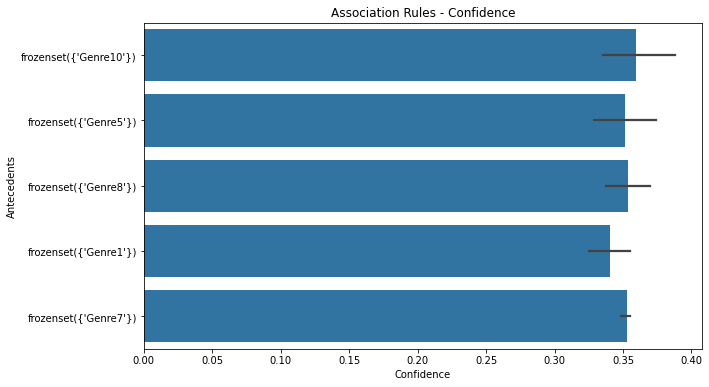

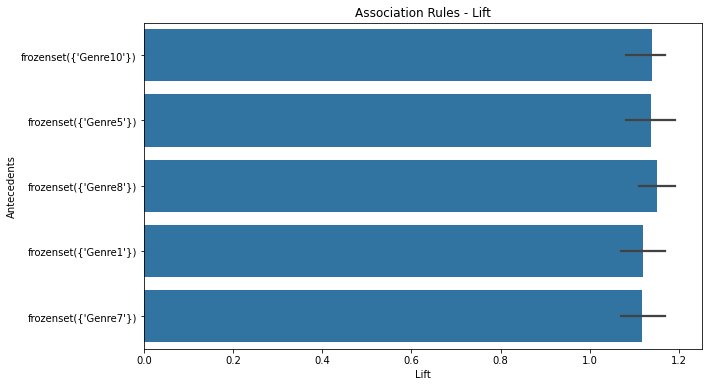

In [503]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns



# Load the dataset from CSV
csv_file = "streaming_preferences_dataset.csv"  
df = pd.read_csv(csv_file)

# Convert the itemsets to boolean values
df = df.astype(bool)
print(df.dtypes)

# Apriori algorithm
min_support = 0.1  
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

# Print frequent itemsets for debugging
print("Frequent Itemsets:")
print(frequent_itemsets)

# Association rules
min_confidence = 0.5  
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_confidence)


# Print association rules for debugging
print("\nAssociation Rules:")
print(rules)

# Sort the rules by confidence
sorted_rules = rules.sort_values(by='confidence', ascending=False)

# Plot bar chart for confidence
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents', data=sorted_rules)
plt.title('Association Rules - Confidence')
plt.xlabel('Confidence')
plt.ylabel('Antecedents')
plt.show()

# Plot bar chart for lift
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='antecedents', data=sorted_rules)
plt.title('Association Rules - Lift')
plt.xlabel('Lift')
plt.ylabel('Antecedents')
plt.show()


Support Error Function: Defines a function support_error to compute the percentage error between the reconstructed support and the actual support of an itemset.

Identity Error Function: Defines a function identity_error to compute the identity error, which measures the discrepancy between the actual and reconstructed sets of frequent itemsets.

Loading and Distorting the Real Dataset: Loads a real dataset from a CSV file, converts it to a NumPy array, and then distorts the dataset using a given privacy factor.

Computing Reconstruction Probabilities: Calculates the reconstruction probabilities for each item in the distorted dataset.

Computing General Reconstruction Probability: Utilizes the reconstruction probabilities to compute the general reconstruction probability based on a given weight parameter.

Computing Privacy Measure: Computes the privacy measure based on the general reconstruction probability.

Evaluating and Interpreting Results: Evaluates and interprets the results obtained from the reconstruction process, including reconstruction probabilities and privacy measures.

Calculating Identity Errors for 1-Itemsets: Computes the identity errors (σ+ and σ-) for the 1-itemsets, comparing the reconstructed set with the correct set of frequent itemsets.

In [514]:
import pandas as pd
import numpy as np

def support_error(reconstructed_support, actual_support):
    return np.abs(reconstructed_support - actual_support) / actual_support * 100

def identity_error(reconstructed_set, correct_set):
    false_positives = len(set(map(frozenset, reconstructed_set)) - set(map(frozenset, correct_set)))
    false_negatives = len(set(map(frozenset, correct_set)) - set(map(frozenset, reconstructed_set)))
    total_frequent_itemsets = len(correct_set)
    
    sigma_plus = false_positives / total_frequent_itemsets * 100
    sigma_minus = false_negatives / total_frequent_itemsets * 100
    
    return sigma_plus, sigma_minus

# Load real dataset 
file_path = 'streaming_preferences_dataset.csv'
real_dataset_df = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
real_dataset = real_dataset_df.to_numpy()

# Define privacy factor
privacy_factor = 0.2
a = 0.7

# Apply distortion
distorted_dataset = distort_user_data(real_dataset, privacy_factor)


# Display the distorted dataset
display_bit_vectors(real_dataset, distorted_dataset)

# Compute reconstruction probabilities
reconstruction_probabilities = []
for i in range(len(distorted_dataset)):
    for j in range(len(distorted_dataset[i])):
        true_value = real_dataset[i, j]
        distorted_value = distorted_dataset[i, j]
        reconstruction_probabilities.append(compute_reconstruction_probability(true_value, distorted_value, privacy_factor))

# Compute general reconstruction probability
general_reconstruction_probability = compute_general_reconstruction_equation(privacy_factor, reconstruction_probabilities, a)

# Compute privacy measure
privacy_measure = compute_privacy_measure(general_reconstruction_probability)

# Evaluate and interpret results
evaluate_and_interpret_results(reconstruction_probabilities, general_reconstruction_probability, privacy_measure, a)

# Extract the actual reconstructed set for 1-itemsets from the distorted dataset
reconstructed_set_1 = [set(np.where(distorted_dataset[:, i] == 1)[0]) for i in range(distorted_dataset.shape[1])]

#  set of frequent itemsets for 1-itemsets
correct_set_1 = [{1, 2}, {4}, {2, 4}, {1, 3, 5}, {1, 4, 5}, {3}, {2}, {1, 2, 4, 5}, {3, 5}, {2, 3}]

# Calculate identity errors
sigma_plus_1, sigma_minus_1 = identity_error(reconstructed_set_1, correct_set_1)
print("Identity Error (σ+) for 1-itemsets:", sigma_plus_1)
print("Identity Error (σ-) for 1-itemsets:", sigma_minus_1)

Original Database:
[[0 1 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]

Distorted Database:
[[1 0 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 1]
 [0 1 0 ... 1 1 1]
 [1 1 1 ... 1 1 0]]
Reconstruction Probabilities for Each Entry:
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,

Selecting a Specific Row: Chooses a specific row from the dataset for demonstration purposes.

Defining Privacy Factor and Epsilon Values: Sets the privacy factor (privacy_factor) and epsilon values (epsilon1 and epsilon2) for the differential privacy mechanism.

Calculating Number of 1's and 0's: Computes the number of 1's (n) and 0's (m) in the selected row.

Defining a Function to Calculate P_E: Defines a function calculate_PE to compute the privacy loss (P_E) based on the binomial distribution.

Calculating P_E for Initial and Distorted Columns: Calculates P_E for the initial and distorted columns based on the given privacy factor and epsilon values.

Calculating Reconstruction Error Bounds: Computes the reconstruction error bounds (delta_n) based on the epsilon values.

Printing the Results: Prints the calculated values for the number of 1's and 0's, P_E for the initial and distorted columns, and the reconstruction error bounds.

In [515]:
import numpy as np
from scipy.stats import binom

# Load the dataset
file_path = 'streaming_preferences_dataset.csv'
dataset_df = pd.read_csv(file_path)

# Choose a specific row for demonstration 
selected_row = dataset_df.iloc[0]

# Define privacy factor (p)
privacy_factor = 0.2

# Define epsilon values
epsilon1 = 0.05
epsilon2 = 0.05

# Calculate n (number of 1's) and m (number of 0's) for the selected row
n = selected_row.sum()
m = len(selected_row) - n

# Define the function to calculate P_E
def calculate_PE(n, p, epsilon):
    r_values = np.arange(np.ceil(n - epsilon), np.floor(n + epsilon) + 1)
    probabilities = binom.pmf(r_values, n, p)
    return np.sum(probabilities)

# Calculate P_E for the initial column
PE_initial = calculate_PE(m, privacy_factor, epsilon1)

# Calculate P_E for the distorted column
PE_distorted = calculate_PE(n, privacy_factor, epsilon2)

# Calculate the reconstruction error bounds
delta_n0 = epsilon1 + epsilon2
delta_n = delta_n0 / (2 * privacy_factor - 1)

# Print the results
print(f"Number of 1's (n): {n}")
print(f"Number of 0's (m): {m}")
print(f"P_E for initial column: {PE_initial}")
print(f"P_E for distorted column: {PE_distorted}")
print(f"Reconstruction error bounds (delta_n): {delta_n}")


Number of 1's (n): 3
Number of 0's (m): 7
P_E for initial column: 1.280000000000001e-05
P_E for distorted column: 0.008000000000000002
Reconstruction error bounds (delta_n): -0.16666666666666669
